# Methods for Sampling from the Unit Simplex 

## 1. Uniform Distributions on the Unit Simplex
A $\textit{n}$-unit simplex (https://en.wikipedia.org/wiki/Simplex#The_standard_simplex) is defined as the subset of $\mathbb{R}^{n+1}$ given by
$\Delta^{n} = \{(x_1,x_2,...,x_{n+1}) \in \mathbb{R}^{n+1} | \sum_{k=1}^{n+1}{x_k}=1; x_k \geq 0, k = 1,2,...,n+1\}$. Methods for sampling directly from the uniform distribution on this $\textit{n}$-unit simplex is not that obvious. The easiest method I have found for this task is from Luc Devroye's book "$\textbf{Non-Uniform Random Variate Generation} $" $\textbf{Chapter V}$ (http://www.nrbook.com/devroye/Devroye_files/chapter_five.pdf). This method utilizes the spacing between order statistics of random samples from the uniform distribution between 0 and 1.

For simplicity and easy visilization, here we sample from the $\textbf{3-unit simplex}$.

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [12]:
## generate order statistics from uniform distribution between 0 and 1
U = [[np.random.uniform(), np.random.uniform()] for i in range(50000)]
for u in U:
    u.sort()

<IPython.core.display.Javascript object>


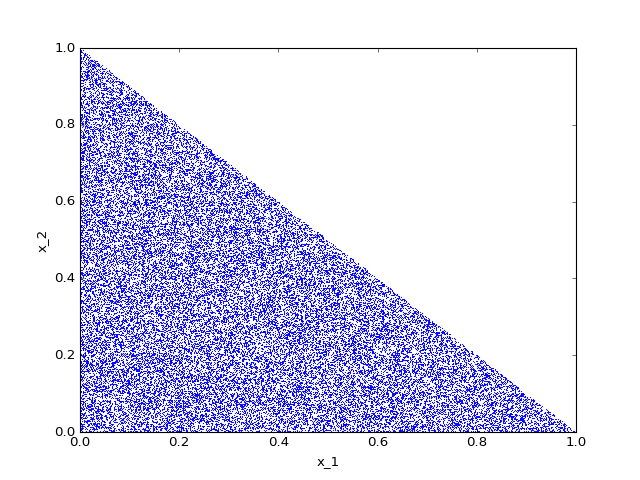

In [18]:
## calculate the spacing and plot the sampling results
x_1 = [u[0] for u in U]
x_2 = [u[1]-u[0] for u in U]
plt.plot(x_1,x_2,'.',markersize = 1)
plt.xlabel(r'x_1')
plt.ylabel(r'x_2')

## 2. Exponential Distributions on the Unit Simplex

The exponential distribution on the $\textit{n}$-unit simplex $\Delta^n$ is defined as:

$$p((x_1,x_2,...,x_{n+1})) = \frac{\text{exp}(a_1 x_1 + a_2 x_2 + ... + a_{n+1}x_{n+1})}{Z}$$
$\text{where    }(x_1,x_2,...,x_{n+1}) \in \Delta^n;$
$Z = \sum_{i=1}^{n+1}{\frac{\text{exp}(a_i)}{\prod_{j\neq i}{(a_i - a_j)}}},$ and $a_1,a_2,...,a_{n+1}$ are constants

This distribution arise from one of my research projects. In the project, sampling from the distribution is required. I originally thought that the distribution seems pretty standard and there must be some standard method for sampling directly from it, like the method for sampling from the uniform distribution on the unit simplex. However, after some searching, I realize it is not the case. I still do not find existing methods for sampling directly from it.

To work around it, I turn to Markov Chain Monte Carlo method.

### 2.1 Gibbs Sampler

### 2.2 Hit-and-Run Sampler